# Plotting Rainfall Rates using NEXRAD Data and PyART

### This code attempts to use Amazon S3 to access the radar files versus manually downloading them all individually.

In [1]:
import warnings
warnings.filterwarnings('ignore')

from pylab import *
import pyart, boto3, tempfile, os, shutil, datetime, matplotlib
import numpy as np
import pandas as pd
import pylab as pl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib import animation
from botocore.handlers import disable_signing
from glob import glob
import xarray as xr


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
# Obtaining radar scans like in the 'Radar Loops' code. This is so the files don't need
# to be downloaded individually.
def get_radar_scan(station='KLOT', date=None, key_index=-20):
    
    '''
    Function will pull the latest radar scan from any radar site using 
    Amazon S3.
    ----------
    Station = Four letter NEXRAD identifier
              Example: 'KEPZ'
    Date = default is none for current date, else enter date in format "YYYY/MM/DD"
    Ex: date ='2013/11/17
    Key_index = Number of keys you want pulled from most recent scan.
    Ex: key_index = -15 would pull ht most recent 15 scans
    '''
    
    # Creating a bucket and a client to be able to pull data from AWS and setting it as unsigned
    bucket = 'noaa-nexrad-level2'
    s3 = boto3.resource('s3')
    s3.meta.client.meta.events.register('choose-signer.s3.*', disable_signing)
    
    # Connects the bucket create above with radar data
    aws_radar = s3.Bucket(bucket)
    
    # Setting the date and time to current...
    # This will allow for allow the current date's radar scands to be pulled
    if date == None:
        target_string = datetime.datetime.utcnow().strftime('%Y/%m/%d/'+station)
    else:
        target_string = date+'/'+station
    
    for obj in aws_radar.objects.filter(Prefix= target_string):
        '{0}:{1}'.format(aws_radar.name, obj.key)
    my_list_of_keys = [this_object.key for this_object in aws_radar.objects.filter(Prefix= target_string)]
    keys = my_list_of_keys[key_index:]
    for key in keys:
        if 'MDM' in key:
            keys.remove(key)
    print(keys)
    return aws_radar, keys

In [3]:
# Setting radar, date of radar scans needed, and key index (amount of items in list)
aws_radar, keys = get_radar_scan(station='KLOT', date='2013/04/18', key_index=-400) 
out_path_dir = 'home/amedendorp/Desktop/april182013'

['2013/04/18/KLOT/KLOT20130418_000354_V06.gz', '2013/04/18/KLOT/KLOT20130418_000810_V06.gz', '2013/04/18/KLOT/KLOT20130418_001228_V06.gz', '2013/04/18/KLOT/KLOT20130418_001645_V06.gz', '2013/04/18/KLOT/KLOT20130418_002102_V06.gz', '2013/04/18/KLOT/KLOT20130418_002518_V06.gz', '2013/04/18/KLOT/KLOT20130418_002934_V06.gz', '2013/04/18/KLOT/KLOT20130418_003350_V06.gz', '2013/04/18/KLOT/KLOT20130418_003807_V06.gz', '2013/04/18/KLOT/KLOT20130418_004223_V06.gz', '2013/04/18/KLOT/KLOT20130418_004639_V06.gz', '2013/04/18/KLOT/KLOT20130418_005057_V06.gz', '2013/04/18/KLOT/KLOT20130418_005514_V06.gz', '2013/04/18/KLOT/KLOT20130418_005932_V06.gz', '2013/04/18/KLOT/KLOT20130418_010349_V06.gz', '2013/04/18/KLOT/KLOT20130418_010806_V06.gz', '2013/04/18/KLOT/KLOT20130418_011223_V06.gz', '2013/04/18/KLOT/KLOT20130418_011640_V06.gz', '2013/04/18/KLOT/KLOT20130418_012057_V06.gz', '2013/04/18/KLOT/KLOT20130418_012513_V06.gz', '2013/04/18/KLOT/KLOT20130418_013141_V06.gz', '2013/04/18/KLOT/KLOT20130418_013

In [4]:
# Obtaining every 7th step (approximately every half hour). 
# Leave blank bracket to include all timesteps.
nk = keys[0:350]

In [34]:
#turing the data into grid data and saving it to a folder

def get_grid(aws_radar, nk):
    localfile = tempfile.NamedTemporaryFile()
    aws_radar.download_file(nk, localfile.name)
    radar = pyart.io.read(localfile.name)
    rr = pyart.retrieve.est_rain_rate_z(radar, alpha=0.0376, beta=0.6112, refl_field=None, rr_field=None)
    radar.add_field('rain_rate', rr, replace_existing=True)
    # Mask out last 10 gates of each ray, this removes the "ring" around the radar.
    radar.fields['rain_rate']['data'][:, -10:] = np.ma.masked

    gatefilter = pyart.filters.GateFilter(radar)
    gatefilter.exclude_transition()
    gatefilter.exclude_masked('rain_rate')
    grid = pyart.map.grid_from_radars(
            (radar, ), grid_shape=(1, 300, 300),
            grid_limits=((2000, 2000), (-123000.0, 123000.0), (-123000.0, 123000.0)),
            fields=['rain_rate'], weighting_function='Barnes2',
            gridding_algo='map_gates_to_grid',
            h_factor=0., nb=0.6, bsp=1., min_radius=500., gatefilters=(gatefilter, ))
    del radar
    return grid

for num,key in enumerate(nk):
    print('saving grid', num)
    grid = get_grid(aws_radar, key)
    name = os.path.join('/home/amedendorp/Desktop/SAVUER/Rainfall_Rates/grid_' + str(num).zfill(3) + '.nc')
    pyart.io.write_grid(name, grid)
    del grid


saving grid 0
saving grid 1
saving grid 2
saving grid 3
saving grid 4
saving grid 5
saving grid 6
saving grid 7
saving grid 8
saving grid 9
saving grid 10
saving grid 11
saving grid 12
saving grid 13
saving grid 14
saving grid 15
saving grid 16
saving grid 17
saving grid 18
saving grid 19
saving grid 20
saving grid 21
saving grid 22
saving grid 23
saving grid 24
saving grid 25
saving grid 26
saving grid 27
saving grid 28
saving grid 29
saving grid 30
saving grid 31
saving grid 32
saving grid 33
saving grid 34
saving grid 35
saving grid 36
saving grid 37
saving grid 38
saving grid 39
saving grid 40
saving grid 41
saving grid 42
saving grid 43
saving grid 44
saving grid 45
saving grid 46
saving grid 47
saving grid 48
saving grid 49
saving grid 50
saving grid 51
saving grid 52
saving grid 53
saving grid 54
saving grid 55
saving grid 56
saving grid 57
saving grid 58
saving grid 59
saving grid 60
saving grid 61
saving grid 62
saving grid 63
saving grid 64
saving grid 65
saving grid 66
savin

TypeError: Unknown or unsupported file format: UNKNOWN

In [5]:
import cartopy.io.shapereader as shpreader

reader = shpreader.Reader('/home/amedendorp/Downloads/countyl010g_shp_nt00964/countyl010g.shp')
counties = list(reader.geometries())
COUNTIES = cfeature.ShapelyFeature(counties, ccrs.PlateCarree())

In [6]:
# Creating an animation of the GOES grids using PyART
from matplotlib.animation import FuncAnimation
import glob

files = glob.glob('/home/amedendorp/Desktop/SAVUER/Rainfall_Rates/grid*')
files.sort()

In [7]:
import cartopy

In [8]:
import pyart

<function matplotlib.pyplot.close(fig=None)>

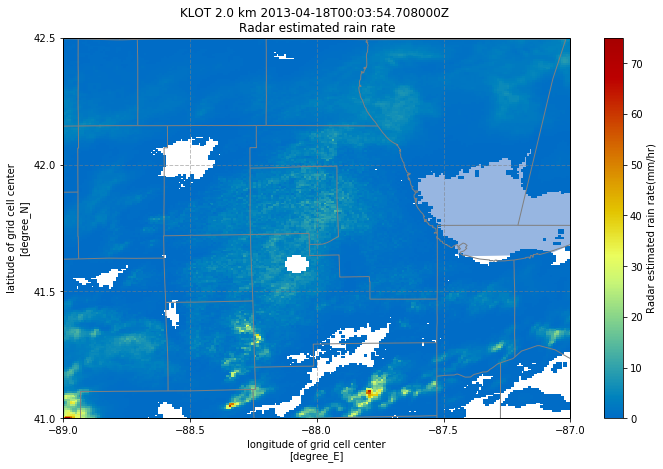

In [10]:
def rr_animation(nframe): 
    plt.clf()
    nfile = files[nframe]
    
    radar = pyart.io.read_grid(nfile)
    projection = ccrs.PlateCarree()
    
    ax = plt.axes(projection=projection)
    
    display = pyart.graph.GridMapDisplay(radar)
    display.plot_grid('rain_rate', cmap=pyart.graph.cm_colorblind.HomeyerRainbow,
                      vmin=0, vmax=75, lat_lines=np.arange(41, 43, .5),
                      lon_lines=np.arange(-89, -86.5, .5), projection=projection, embelish=True)
    del radar, display
    ax.add_feature(COUNTIES, facecolor='none', edgecolor='gray')
    ax.add_feature(cfeature.LAKES, zorder=.5)


fig = plt.figure(figsize=[12,7])

# Match the frames to the amount of grids
sat_anim = FuncAnimation(fig, rr_animation, frames=150)
sat_anim.save('/home/amedendorp/Desktop/SAVUER/Rainfall_Rates/rain_rate.gif',
              writer='imagemagick', fps=4)
plt.close
